# Predator-Prey model with triangular transport map
Based on "Transport map accelerated Markov chain Monte Carlo" by Parno and Marzouk (SIAM/ASA Journal on Uncertainty Quantification 2018)

In [1]:
# %env JAX_DEBUG_NANS=True
import jax
import jax.numpy as np
import numpy as onp
import numpyro
from numpyro.contrib.autoguide import AutoDelta
from numpyro import distributions as dist
from numpyro.distributions import constraints
from numpyro.examples.runge_kutta import runge_kutta_4
from numpyro.infer import init_to_median, init_with_noise
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import OrderedDict

In [2]:
rng_key = jax.random.PRNGKey(242)

## Predator Prey Model

In [3]:
def predator_prey_step(t, state, r=0.6, k=100, s=1.2, a=25, u=0.5, v=0.3):
    prey = state[..., 0]
    predator = state[..., 1]
    sh = (prey * predator)/(a + prey + 1e-3)
    prey_upd = r * prey * (1 - prey / (k + 1e-3)) - s * sh
    predator_upd = u * sh - v * predator
    return np.stack((prey_upd, predator_upd), axis=-1)
num_time = 50
step_size = 0.1
num_steps = int(num_time / step_size)
dampening_rate = 0.9
lyapunov_scale = 10e-4
clip = lambda x: np.clip(x, -50.0, 50.0)
predator_prey = jax.partial(runge_kutta_4, predator_prey_step, step_size, num_steps, dampening_rate,
                            lyapunov_scale, clip, rng_key)

In [4]:
indices = np.array([1, 11, 21, 31, 41])
res, lyapunov_loss = predator_prey(np.array([50., 5.]))
res = np.reshape(res, (num_time, num_steps // num_time, -1))[:, 0, :]
noise = jax.random.normal(rng_key, (1000,5,2)) * 10
data = (indices, res[indices] + noise)
data

(DeviceArray([ 1, 11, 21, 31, 41], dtype=int32),
 DeviceArray([[[ 48.369736 , -12.506602 ],
               [ 84.83046  ,  13.477432 ],
               [ 50.69157  ,  20.842863 ],
               [ 35.402466 ,  26.523859 ],
               [ 37.76766  ,   4.227916 ]],
 
              [[ 79.87219  ,   8.722676 ],
               [101.32492  ,  13.651097 ],
               [ 30.157503 ,  14.258831 ],
               [ 23.036427 ,  26.26771  ],
               [ 26.759478 ,  14.439317 ]],
 
              [[ 54.11634  ,  -8.428648 ],
               [ 86.56836  ,  16.871895 ],
               [ 45.39682  ,  37.686134 ],
               [ 20.329535 ,  37.97989  ],
               [ 33.48458  ,  18.562016 ]],
 
              ...,
 
              [[ 74.52628  ,  17.532393 ],
               [ 81.17423  ,  12.432698 ],
               [ 59.679417 ,  24.360798 ],
               [ 24.446838 ,  30.210197 ],
               [ 38.015095 ,  11.464539 ]],
 
              [[ 69.41638  ,  -6.335142 ],
               

In [5]:
def model(indices, observations):
    prior_dist = dist.Uniform(0.1, 50.)
    prey0 = numpyro.sample('prey0', prior_dist)
    predator0 = numpyro.sample('predator0', prior_dist)
    r = numpyro.sample('r', prior_dist)
    k = numpyro.sample('k', prior_dist)
    s = numpyro.sample('s', prior_dist)
    a = numpyro.sample('a', prior_dist)
    u = numpyro.sample('u', prior_dist)
    v = numpyro.sample('v', prior_dist)
    ppres, lyapunov_loss = predator_prey(np.array([prey0, predator0]), r=r, k=k, s=s, a=a, u=u, v=v)
    ppres = np.reshape(ppres, (num_time, num_steps // num_time, -1))[:, 0, :]
    numpyro.factor('lyapunov_loss', lyapunov_loss)
    numpyro.sample('obs', dist.Normal(ppres[indices], 10.0).to_event(2), obs=observations)

### Guide and Stein with Transport Maps

In [9]:
svgd = numpyro.infer.SVGD(model, AutoDelta(model, init_strategy=init_to_median()), 
                          numpyro.optim.Adam(1e-5), numpyro.infer.ELBO(),
                          numpyro.infer.kernels.RBFKernel(), num_particles=100,
                          repulsion_temperature=0.001 * data[1].shape[0])
state, loss = svgd.run(rng_key, 10000, *data)  # rounds 10000

SVGD nan:   4%|▎         | 363/10000 [01:16<33:48,  4.75it/s]


KeyboardInterrupt: 

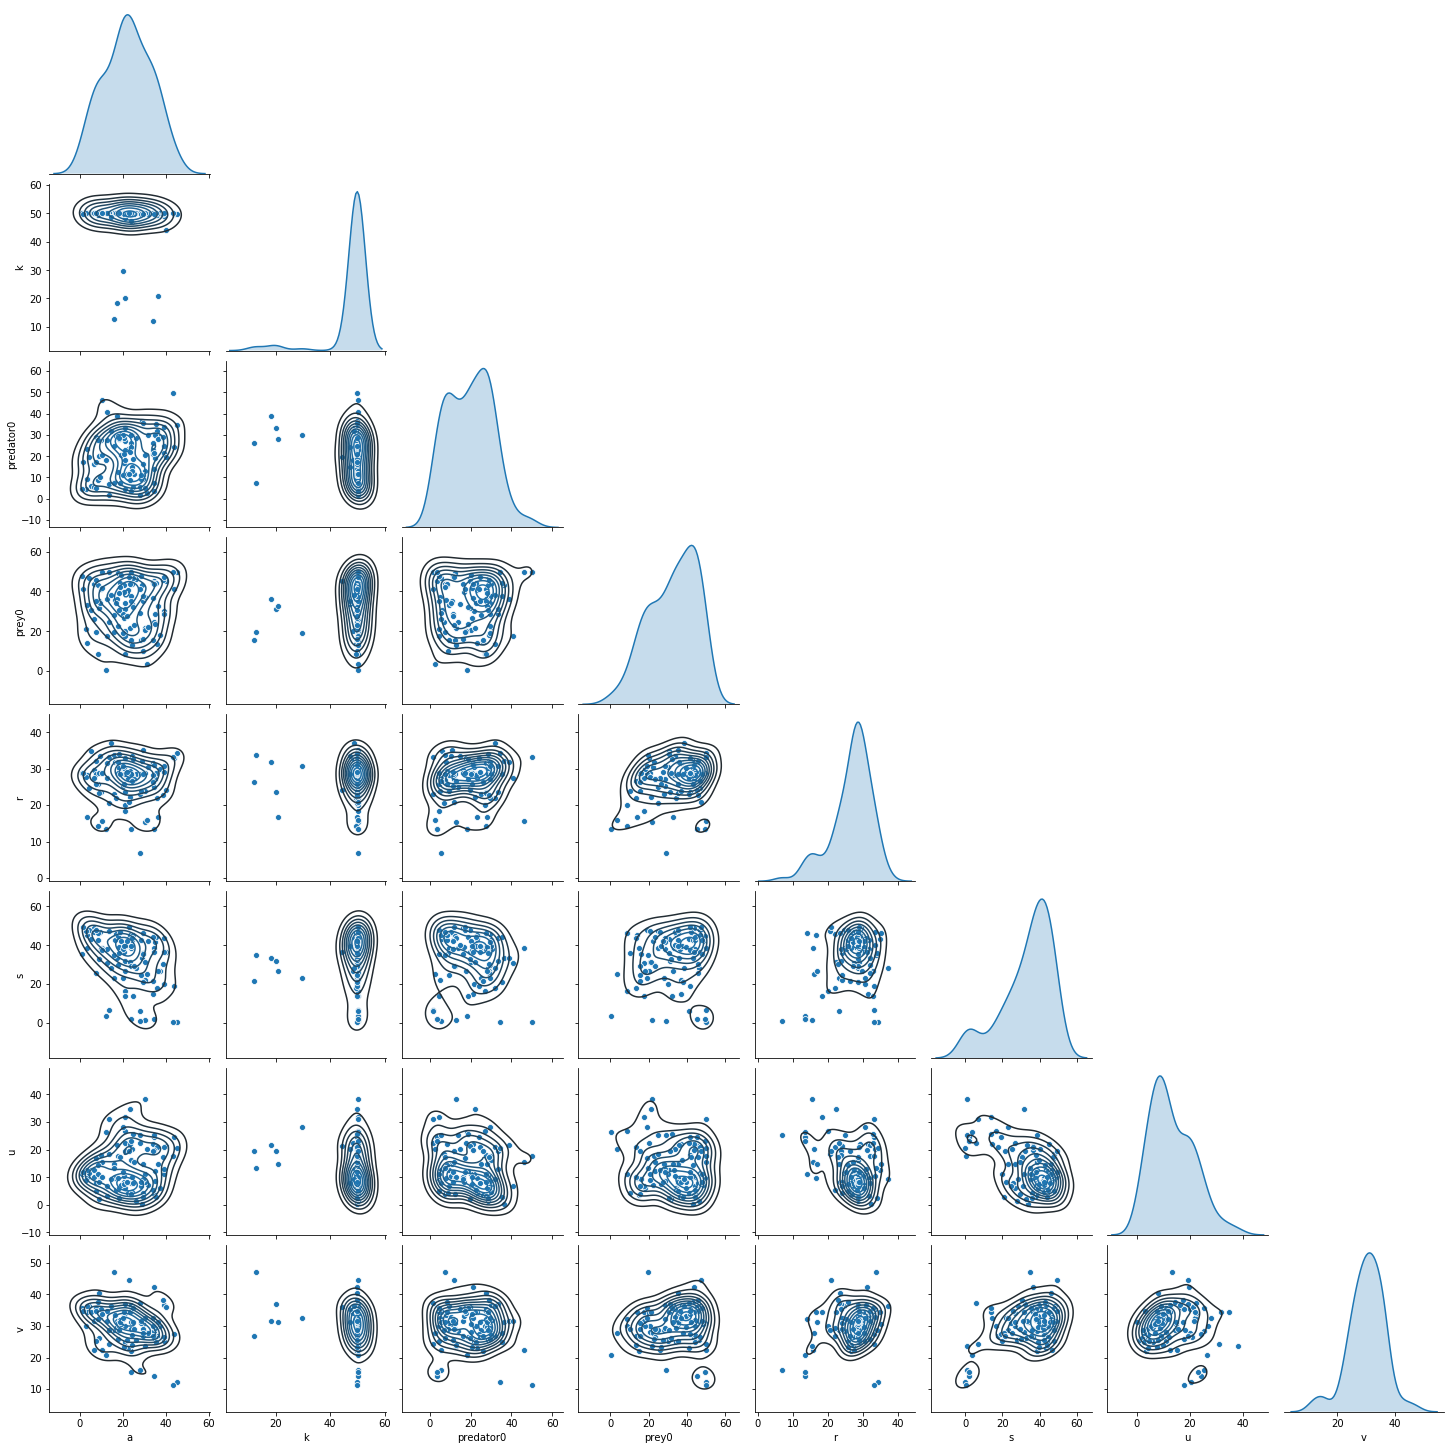

In [17]:
sample_frame = pd.DataFrame.from_dict(svgd.predict(state, *data))
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)

In [25]:
def transmap_guide(indices, observations):
    param_keys = {'prey0', 'preadtor0', 'r', 'k', 's', 'a', 'u', 'v'}
    params = OrderedDict()
    for k in param_keys:
        params[k] = numpyro.param(f'{k}$val', 25.)
    tmapp = numpyro.param('tmapp', np.zeros(8 * (8 + 1) // 2))
    tril_idx = np.tril_indices(8)
    tmap = jax.ops.index_update(np.zeros((8, 8)), tril_idx, tmapp)
    tloc = numpyro.param('tloc', np.zeros(8))
    tvals = jax.nn.sigmoid(tmap @ np.array(list(params.values())) + tloc) * 49.9 + 0.1
    for pk, tval in zip(params.keys(), tvals):
        if pk == 'k':
            tval = tval + 1
        numpyro.sample(pk, dist.Delta(tval))

In [27]:
svgd = numpyro.infer.SVGD(model, numpyro.guides.WrappedGuide(transmap_guide, init_strategy=init_with_noise(init_to_median(), 10.0)), 
                          numpyro.optim.Adam(0.01), numpyro.infer.ELBO(),
                          numpyro.infer.kernels.RBFKernel(), repulsion_temperature=0.001 * data[1].shape[0],
                          num_particles=100,
                          classic_guide_params_fn=lambda n: n in {'tmapp', 'tloc'})
state, loss = svgd.run(rng_key, 10000, *data)


SVGD nan:   0%|          | 16/10000 [00:48<8:23:43,  3.03s/it]


KeyboardInterrupt: 

In [ ]:
sample_frame = pd.DataFrame(svgd.predict(state, *data))
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)

### NUTS MCMC Sampling

In [ ]:
mcmc = numpyro.infer.MCMC(numpyro.infer.NUTS(model), 100, 500, chain_method='vectorized')
mcmc.run(rng_key, *data)
mcmc.print_summary()

In [ ]:
samples = mcmc.get_samples()
sample_frame = pd.DataFrame(samples)
g = sns.pairplot(sample_frame, corner=True, diag_kind='kde')
g.map_lower(sns.kdeplot, lw=2)